# Imports

In [12]:
!pip install torch

In [13]:
import pandas as pd
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
import torch

# Download Data

In [14]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1tDw00yLk42PhSndvrpzJrLnu6ydQIY2b' -O raw_single_cell_tcr_data_acs_controllers_and_progressors.csv
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1uZuac6-X6_6rTZRkmNkASJFtOvt3-Mis' -O immunoSeq_samples_key.csv
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1S7wYkHOOLJtb7O6GjhtmIk8aQmDgwi3D' -O study_sample_key.csv

--2024-05-06 00:43:56--  https://drive.google.com/uc?export=download&id=1tDw00yLk42PhSndvrpzJrLnu6ydQIY2b
Resolving drive.google.com (drive.google.com)... 64.233.170.138, 64.233.170.101, 64.233.170.100, ...
Connecting to drive.google.com (drive.google.com)|64.233.170.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1tDw00yLk42PhSndvrpzJrLnu6ydQIY2b&export=download [following]
--2024-05-06 00:43:56--  https://drive.usercontent.google.com/download?id=1tDw00yLk42PhSndvrpzJrLnu6ydQIY2b&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.194.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41943373 (40M) [application/octet-stream]
Saving to: ‘raw_single_cell_tcr_data_acs_controllers_and_progressors.csv’

raw_single_cell_

# Load Data

In [15]:
df_raw_controllers_and_progressors = pd.read_csv("raw_single_cell_tcr_data_acs_controllers_and_progressors.csv")
df_immunoSeq_samples_key =  pd.read_csv("immunoSeq_samples_key.csv")
df_study_sample_key = pd.read_csv("study_sample_key.csv")

# Merge Data

# Merge dataframes

In [16]:
# Deduplicate IDs based on some logic, here taking the first occurrence
df_immunoSeq_samples_key_unique = df_immunoSeq_samples_key.drop_duplicates(subset=['Donor.ID'], keep='first')
df_study_sample_key_unique = df_study_sample_key.drop_duplicates(subset=['Donor ID'], keep='first')

# First merge and drop
df_merged = pd.merge(
    df_raw_controllers_and_progressors,
    df_immunoSeq_samples_key_unique[['Donor.ID', 'Group']],
    left_on='donorId',
    right_on='Donor.ID',
    how='left'
)
df_merged.drop('Donor.ID', axis=1, inplace=True)

# Second merge and drop
df_merged = pd.merge(
    df_merged,
    df_study_sample_key_unique[['Donor ID', 'Group']],
    left_on='donorId',
    right_on='Donor ID',
    how='left'
)
df_merged.drop('Donor ID', axis=1, inplace=True)

# Condition where both Group_x and Group_y are not null
condition = (~df_merged['Group_x'].isna()) & (~df_merged['Group_y'].isna())

# Check if there are any disagreements
disagreements = df_merged[condition & (df_merged['Group_x'] != df_merged['Group_y'])]
if not disagreements.empty:
    raise ValueError(f"Disagreement found in rows: {disagreements.index.tolist()}")

# Combine Group_x and Group_y into a single column, preferring Group_x values
df_merged['Group'] = df_merged['Group_x'].combine_first(df_merged['Group_y'])

In [17]:
df_merged

,Unnamed: 0,plateBC,well,PID,project,seqName,seqId,batch,himcBC,batch_bc_well,...,CD154,TCRab,MAIT.Match.Score,MAIT.Classification,Cell.Type,sex,age_at_enrolment,Group_x,Group_y,Group
0,1,1282040.0,A1,04-0333-D180,SI-21 TB Progressor,M04104,198.0,SI21_TB_b22,BC2,SI21_TB_b22_BC2_A1,...,1287.960,6990.688,0.7932,Non.MAIT,CD4,female,17,Controller,Controller,Controller
1,2,1282040.0,A10,04-0333-D180,SI-21 TB Progressor,M04104,198.0,SI21_TB_b22,BC2,SI21_TB_b22_BC2_A10,...,7394.608,693.224,0.9490,Non.MAIT,CD4,female,17,Controller,Controller,Controller
2,3,1282040.0,A11,04-0333-D180,SI-21 TB Progressor,M04104,198.0,SI21_TB_b22,BC2,SI21_TB_b22_BC2_A11,...,4098.718,2926.616,0.8898,Non.MAIT,CD4,female,17,Controller,Controller,Controller
3,4,1282040.0,A2,04-0333-D180,SI-21 TB Progressor,M04104,198.0,SI21_TB_b22,BC2,SI21_TB_b22_BC2_A2,...,4883.382,582.286,NaN,NaN,CD4,female,17,Controller,Controller,Controller
4,5,1282040.0,A3,04-0333-D180,SI-21 TB Progressor,M04104,198.0,SI21_TB_b22,BC2,SI21_TB_b22_BC2_A3,...,484.996,4735.192,0.8768,Non.MAIT,CD4,female,17,Controller,Controller,Controller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37669,37670,1292419.0,E5,07-0386-D540,SI-21 TB Progressor,M04104,197.0,SI21_TB_b21,BC9,SI21_TB_b21_BC9_E5,...,4556.490,2818.737,0.8503,Non.MAIT,CD4,female,17,Progressor,Progressor,Progressor
37670,37671,1292419.0,E6,07-0386-D540,SI-21 TB Progressor,M04104,197.0,SI21_TB_b21,BC9,SI21_TB_b21_BC9_E6,...,3089.124,3336.624,0.8137,Non.MAIT,CD4,female,17,Progressor,Progressor,Progressor
37671,37672,1292419.0,E7,07-0386-D540,SI-21 TB Progressor,M04104,197.0,SI21_TB_b21,BC9,SI21_TB_b21_BC9_E7,...,33560.895,1337.249,0.8509,Non.MAIT,CD4,female,17,Progressor,Progressor,Progressor
37672,37673,1292419.0,E8,07-0386-D540,SI-21 TB Progressor,M04104,197.0,SI21_TB_b21,BC9,SI21_TB_b21_BC9_E8,...,2506.204,2711.545,NaN,NaN,CD4,female,17,Progressor,Progressor,Progressor


In [18]:
print(df_merged.columns.values)
print(df_merged['hla_B(R)'].unique())

['Unnamed: 0' 'plateBC' 'well' 'PID' 'project' 'seqName' 'seqId' 'batch'
 'himcBC' 'batch_bc_well' 'sampleId' 'donorId' 'visit' 'Days.To.TB'
 'plateNo' 'gatingPW' 'stim' 'donorGrp' 'flag' 'wellcount' 'assigned'
 'assignedrate' 'Vb' 'Db' 'Jb' 'CDR3b' 'CDR3b.dominance' 'CDR3b_reads'
 'Va' 'Da' 'Ja' 'CDR3a' 'CDR3a.dominance' 'CDR3a_reads' 'alt.Va' 'alt.Ja'
 'alt.CDR3a' 'alt.CDR3a.dominance' 'alt.CDR3a_reads' 'TCRb.sequence'
 'TCRa.sequence' 'alt.TCRa.sequence' 'hla_A(L)' 'hla_A(R)' 'hla_B(L)'
 'hla_B(R)' 'hla_C(L)' 'hla_C(R)' 'hla_DPA1(L)' 'hla_DPA1(R)'
 'hla_DPB1(L)' 'hla_DPB1(R)' 'hla_DQA1(L)' 'hla_DQA1(R)' 'hla_DQB1(L)'
 'hla_DQB1(R)' 'hla_DRB1(L)' 'hla_DRB1(R)' 'hla_DRB345(L)' 'hla_DRB345(R)'
 'BCL6' 'EOMES' 'FOXP3' 'GATA3' 'GZMB' 'IFNG' 'IL10' 'IL12A' 'IL13'
 'IL17A' 'IL2' 'IL21' 'IL4' 'PERF' 'RORC' 'RUNX1' 'RUNX3' 'TBET' 'TGFB'
 'TNF' 'FSC-A' 'FSC-H' 'SSC-A' 'CD69' 'CD8' 'HLA-DR' 'DUMP' 'CD4' 'CD137'
 'CD3' 'CD26' 'CD154' 'TCRab' 'MAIT.Match.Score' 'MAIT.Classification'
 'Cell.Type'

# Pre-Process Data

## Filter relevant columns

In [19]:
# df_merged[["CDR3a", "TCRa.sequence", "TCRb.sequence", "TCRab"]]

In [20]:
dff_merged = df_merged[
    ["donorId", "CDR3a", "Group"]
]

# Convert columns to strings
dff_merged = dff_merged.astype(str)

# Drop rows for which CDR3a is non
dff_merged = dff_merged[dff_merged["CDR3a"] != "nan"]

In [21]:
dff_merged["CDR3a"]

0        CILRDVWGNNARLMF
1           CAVYNYGQNFVF
2        CIVSPINNAGNMLTF
4         CAVTRGTGGFKTIF
5         CAVTPNTGFQKLVF
              ...       
37668     CIVRNSGGYQKVTF
37669       CVVRPGANNLFF
37670      CLVPPTGANNLFF
37671    CAVRLKGGATNKLIF
37673       CAFMINNNDMRF
Name: CDR3a, Length: 22276, dtype: object

In [22]:
dff_merged.dtypes

donorId    object
CDR3a      object
Group      object
dtype: object

# Modeling

In [23]:
from transformers import BertTokenizer

In [24]:
PAD = "$"
MASK = "."
UNK = "?"
SEP = "|"
CLS = "*"

def get_pretrained_bert_tokenizer(path: str) -> BertTokenizer:
    """Get the pretrained BERT tokenizer from given path"""
    tok = BertTokenizer.from_pretrained(
        path,
        do_lower_case=False,
        tokenize_chinese_chars=False,
        unk_token=UNK,
        sep_token=SEP,
        pad_token=PAD,
        cls_token=CLS,
        mask_token=MASK,
        padding_side="right",
        truncation=True,
        padding = True,
        return_tensors = 'pt'
    )
    return tok

In [25]:
sequences = dff_merged["CDR3a"].tolist()

In [26]:
seq_w_whitespace = [
    " ".join(list(seq)) for seq in sequences
]

In [27]:
from transformers import BertModel
# This model was pretrained on MAA and TRB classification
tcrbert_model = BertModel.from_pretrained("wukevin/tcr-bert")
tcrbert_tokenizer = get_pretrained_bert_tokenizer("wukevin/tcr-bert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.64k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/230M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/91.0 [00:00<?, ?B/s]

In [28]:
# Tokenize Sequence
inputs = tcrbert_tokenizer(
    seq_w_whitespace,
    return_tensors="pt",
    max_length=128,
    padding=True,
    add_special_tokens=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2692: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [29]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Put model and inputs on device
tcrbert_model = tcrbert_model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

In [30]:
with torch.no_grad():
    outputs = tcrbert_model(**inputs)

In [31]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.3248, -0.2858,  1.2048,  ...,  0.4892,  0.5790,  1.6743],
         [ 0.7434, -1.3410,  1.7243,  ..., -0.4873, -0.0985,  0.6679],
         [-0.2184,  0.4703,  2.6175,  ..., -0.5072, -0.5179,  0.3675],
         ...,
         [-2.4709, -0.0717, -0.3465,  ..., -0.6243,  0.3134,  1.0563],
         [-2.2365, -0.0499, -0.7850,  ..., -0.4483,  0.7217,  1.0873],
         [-2.5062, -0.2906, -0.6281,  ..., -0.6056,  1.0012,  1.2905]],

        [[-0.2178, -1.0668,  0.0867,  ...,  0.1531, -2.4796,  1.1050],
         [ 0.3629, -1.3774,  0.9175,  ..., -1.2994, -2.1303,  1.4945],
         [-0.1912,  0.5000,  0.9212,  ..., -0.7009, -2.0811,  0.6093],
         ...,
         [-1.2168, -1.0844, -0.8808,  ..., -0.8929, -0.2628,  1.3804],
         [-0.9583, -1.2155, -1.1406,  ..., -0.9837, -0.3877,  1.7599],
         [-1.1319, -1.0591, -0.7255,  ..., -0.8197, -0.2775,  1.6433]],

        [[ 0.3098, -0.1701,  0.0196,  ..., -1.0256,  

In [32]:
# Extracting the [CLS] token's embeddings (assuming they are the first token's output)
embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()  # Make sure to detach and move to CPU


In [33]:
dff_merged['embeddings'] = list(embeddings)

In [34]:
dff_merged

,donorId,CDR3a,Group,embeddings
0,04-0333,CILRDVWGNNARLMF,Controller,"[-0.32483366, -0.28578907, 1.2048455, -1.23306..."
1,04-0333,CAVYNYGQNFVF,Controller,"[-0.21782973, -1.0668253, 0.08671243, 0.650835..."
2,04-0333,CIVSPINNAGNMLTF,Controller,"[0.30981496, -0.1701109, 0.019591331, -1.85406..."
4,04-0333,CAVTRGTGGFKTIF,Controller,"[0.114908576, 0.102618076, -0.50007135, -0.680..."
5,04-0333,CAVTPNTGFQKLVF,Controller,"[0.37916976, 0.0009963448, -0.050300166, -0.73..."
...,...,...,...,...
37668,07-0386,CIVRNSGGYQKVTF,Progressor,"[-1.3121986, -0.5018212, 0.4406116, 1.8342069,..."
37669,07-0386,CVVRPGANNLFF,Progressor,"[-0.17877944, 0.16738518, -0.26593262, -1.4817..."
37670,07-0386,CLVPPTGANNLFF,Progressor,"[-0.6999689, -1.242247, 0.3307893, -0.96245444..."
37671,07-0386,CAVRLKGGATNKLIF,Progressor,"[-0.5948395, 0.37960136, -0.59932, 0.3748059, ..."


In [35]:
# prompt: save dff_merged as csv

# dff_merged.to_csv("processed_data.csv")


In [36]:
# # Group by 'donorID' and calculate the mean of embeddings
# import numpy as np
# average_embeddings = dff_merged.groupby('donorId')['embeddings'].apply(lambda x: np.mean(np.vstack(x), axis=0)).reset_index(name='avg_embeddings')
# # Merge the average embeddings with the original DataFrame to get the 'group' labels
# result_df = average_embeddings.merge(dff_merged[['donorId', 'Group']].drop_duplicates(), on='donorId', how='left')


In [37]:
# # prompt: print donorId  in dff_merged if Group column is not Controller or Progressor

# df_non_controller_progressor = dff_merged[~dff_merged["Group"].isin(["Controller", "Progressor"])]
# non_controller_progressor_donor_ids = df_non_controller_progressor["donorId"].unique()
# for donor_id in non_controller_progressor_donor_ids:
#     print(donor_id)


In [38]:
# result_df

# PCA embeddings

In [39]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

vectors = np.stack(dff_merged['embeddings'].values)

# Step 2: Apply PCA
pca = PCA(n_components=256)  # Reduce to 3 principal components
# print("Explained variance ratio:", pca.explained_variance_ratio_.sum())
pca_embeddings = pca.fit_transform(vectors)

# Step 3: Replace the original data with PCA-reduced embeddings
dff_merged['embeddings'] = list(pca_embeddings)


In [40]:
dff_merged['embeddings'][0].shape

(256,)

In [41]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# dff_merged['embeddings'] = dff_merged['embeddings'].apply(lambda x: torch.tensor(x))

# Now, group by 'donorId' and collect embeddings into a list
grouped = dff_merged.groupby('donorId')['embeddings'].agg(list)

# Convert the grouped data to a DataFrame
grouped_df = pd.DataFrame(grouped)

# Convert group labels to tensor; assume binary classification for simplicity
labels = dff_merged.groupby('donorId')['Group'].first().apply(lambda x: torch.tensor(int(x == 'Controller')))

labels_df = pd.DataFrame(labels)


In [42]:
grouped_df

,embeddings
donorId,
01-0782,"[[2.289569, 2.0206294, 2.7305408, 10.279049, 9..."
01-0935,"[[9.8054905, 3.2632554, 4.3357306, -8.085279, ..."
01-0978,"[[-4.7622323, 11.752474, 2.008612, -5.4123125,..."
01-0993,"[[0.93081176, 4.003913, 7.0929127, -2.2071896,..."
02-0185,"[[8.154273, -12.887654, 1.0534987, -2.7222986,..."
...,...
09-0569,"[[-2.4303694, 7.3127985, -1.7515482, -1.714973..."
09-0581,"[[1.5815065, 0.09812371, -4.6221967, 3.9798317..."
09-0587,"[[-0.2059567, 12.704266, -4.322604, -5.1231265..."


classifying individual sequences

In [43]:
# Sample DataFrame setup
# dff_merged = pd.read_csv('path_to_your_data.csv')  # If loading from a file

# Convert text labels to binary
dff_merged['Group'] = dff_merged['Group'].map({'Controller': 0, 'Progressor': 1})

In [44]:
dff_merged

,donorId,CDR3a,Group,embeddings
0,04-0333,CILRDVWGNNARLMF,0,"[10.513699, -0.25432852, -0.50693387, 14.27556..."
1,04-0333,CAVYNYGQNFVF,0,"[-3.4496782, -2.8899064, -6.148358, -4.1831174..."
2,04-0333,CIVSPINNAGNMLTF,0,"[10.723144, 0.36836272, 2.7485092, 6.421674, 3..."
4,04-0333,CAVTRGTGGFKTIF,0,"[5.7128334, 2.0361567, 0.7288754, -12.119782, ..."
5,04-0333,CAVTPNTGFQKLVF,0,"[2.4186776, 2.9996192, 3.8951085, -7.7919197, ..."
...,...,...,...,...
37668,07-0386,CIVRNSGGYQKVTF,1,"[-4.7759633, -5.263036, -9.830307, -7.3988333,..."
37669,07-0386,CVVRPGANNLFF,1,"[4.3185143, -4.9865055, -6.6828876, 9.221393, ..."
37670,07-0386,CLVPPTGANNLFF,1,"[-0.20705602, -5.5294495, -7.2328024, 12.43699..."
37671,07-0386,CAVRLKGGATNKLIF,1,"[-3.8761847, 2.149977, -12.556888, 0.7696734, ..."


# Save embeddings

# Transformer Approach

In [45]:
len(grouped_df["embeddings"].iloc[0])

601

In [46]:
test_donor_ids = dff_merged["donorId"].unique()[-10:]

In [47]:
df_train = dff_merged.loc[~dff_merged["donorId"].isin(test_donor_ids)]
df_test = dff_merged.loc[dff_merged["donorId"].isin(test_donor_ids)]

## Deep TCR

In [ ]:
!pip install deeptcr

In [ ]:
import sys
sys.path.append('../../')
from DeepTCR.DeepTCR import DeepTCR_WF

# Instantiate training object
DTCR_WF = DeepTCR_WF('Tutorial')

#Load Data from directories
DTCR_WF.Get_Data(directory='../../Data/Rudqvist',Load_Prev_Data=False,aggregate_by_aa=True,
               aa_column_beta=1,count_column=2,v_beta_column=7,d_beta_column=14,j_beta_column=21)

In [ ]:
import pandas as pd
import os

def organize_data_for_deeptcr(df):
    master_folder = 'deeptcr'
    subfolders = ['Class1', 'Class2']
    class_mappings = {'Controller': 'Class1', 'Progressor': 'Class2'}

    # Create the master directory if it doesn't exist
    if not os.path.exists(master_folder):
        os.mkdir(master_folder)

    # Create subdirectories
    for subfolder in subfolders:
        dir_path = os.path.join(master_folder, subfolder)
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)

    # Sum the CDR3a_reads and CDR3b_reads to create a combined count column
    df['combined_counts'] = df['CDR3a_reads'].fillna(0) + df['CDR3b_reads'].fillna(0)

    # Define the necessary columns and their mappings, using 'combined_counts' as the count column
    necessary_columns = {
        'CDR3a': 'aa_column_alpha',
        'CDR3b': 'aa_column_beta',
        'combined_counts': 'count_column',  # Using the new combined counts column
        'Va': 'v_alpha_column',
        'Ja': 'j_alpha_column',
        'Vb': 'v_beta_column',
        'Db': 'd_beta_column',
        'Jb': 'j_beta_column'
    }

    # Forward fill missing CDR3a as before
    if 'CDR3a' in df.columns:
        df['CDR3a'] = df['CDR3a'].fillna(method='ffill')

    # Iterate over the groups and donors to save the data
    for group, subfolder in class_mappings.items():
        class_df = df[df['Group'].str.strip() == group]
        donors = class_df['donorId'].unique()
        for donor in donors:
            donor_df = class_df[class_df['donorId'] == donor]
            file_path = os.path.join(master_folder, subfolder, f'{donor}.csv')
            # Ensure to filter DataFrame to only necessary columns
            columns_to_write = [col for col in necessary_columns.keys() if col in donor_df.columns]
            donor_df.to_csv(file_path, columns=columns_to_write, index=False)
            # print(f'Written {file_path}')


# Example usage
# df = pd.read_csv('your_data.csv')  # Load your DataFrame here
# organize_data_for_deeptcr(df)

organize_data_for_deeptcr(df_merged)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleTCRNet(nn.Module):
    def __init__(self, aa_vocab_size, num_classes, embedding_dim=64):
        super(SimpleTCRNet, self).__init__()
        self.aa_embedding = nn.Embedding(num_embeddings=aa_vocab_size, embedding_dim=embedding_dim)

        # Convolutional layers for sequence data
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Linear layers for integrated processing
        self.fc1 = nn.Linear(64 * 2 + 1, 128)  # Concatenation of pooled features and count
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, aa_seq_alpha, aa_seq_beta, count):
        # Embedding and processing alpha sequence
        x_alpha = self.aa_embedding(aa_seq_alpha).permute(0, 2, 1)  # N, C, L
        x_alpha = F.relu(self.conv1(x_alpha))
        x_alpha = F.max_pool1d(x_alpha, kernel_size=x_alpha.size(2)).squeeze(2)

        # Embedding and processing beta sequence
        x_beta = self.aa_embedding(aa_seq_beta).permute(0, 2, 1)
        x_beta = F.relu(self.conv1(x_beta))
        x_beta = F.max_pool1d(x_beta, kernel_size=x_beta.size(2)).squeeze(2)

        # Concatenate all features
        x = torch.cat([x_alpha, x_beta, count.unsqueeze(1)], dim=1)

        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Model instantiation example
num_aa_types = 20  # Example for 20 different amino acids
num_classes = 10  # Adjust based on your classification needs

model = SimpleTCRNet(aa_vocab_size=num_aa_types, num_classes=num_classes)


## Create Datasets

In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class TCRDataset(Dataset):
    def __init__(self, dataframe, pad_length=None):
        self.embeddings = dataframe['embeddings'].tolist()
        self.labels = dataframe['Group'].tolist()

    #     # Calculate the maximum length of embeddings in the dataset if not provided
    #     self.pad_length = pad_length or max(len(seq) for seq in self.embeddings)

    #     # Preprocess and pad embeddings
    #     self.padded_embeddings = [self.pad_embedding(seq) for seq in self.embeddings]

    # def pad_embedding(self, embedding):
    #     # Assuming all embeddings are the same length, else handle variable lengths here
    #     padded = torch.zeros((self.pad_length, len(embedding[0])))
    #     actual_length = min(self.pad_length, len(embedding))
    #     padded[:actual_length] = torch.tensor(embedding[:actual_length])
    #     return padded

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, index):
        # Convert label to tensor for consistency in PyTorch
        return self.embeddings[index], torch.tensor(self.labels[index], dtype=torch.long)

# Example initialization of your dataset
dataset_train = TCRDataset(df_train)
dataset_test = TCRDataset(df_test)


# Assuming you have loaded your DataFrame as `df`
# dataset = TCRDataset(grouped_df, labels_df)
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=2, shuffle=False)

## Define Model

In [49]:

import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, emb_size, num_heads, num_classes, dim_feedforward=256, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.transformer_block = nn.TransformerEncoderLayer(
            d_model=emb_size,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        # x: [batch_size, seq_len, emb_size]
        # Transformer expects [seq_len, batch_size, emb_size]
        # print(x.shape)
        x = x.unsqueeze(1)
        x = x.permute(1, 0, 2)
        x = self.transformer_block(x)
        x = x.permute(1, 0, 2)
        # Apply classifier to each sequence element
        logits = self.classifier(x.mean(dim=1))
        return logits

# Assuming embedding size of 128, 4 heads, and binary classification
model = TransformerClassifier(emb_size=256, num_heads=2, num_classes=2)

## Train Model

In [55]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Assume `train_loader` and `test_loader` are already defined
num_epochs = 20

train_accuracies = []
test_accuracies = []
epoch_losses = []  # Store average loss per epoch

for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode
    total_train = 0
    correct_train = 0
    total_loss = 0

    for embeddings, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(embeddings.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}, Train Accuracy: {train_acc:.2f}%')

    model.eval()
    total_test = 0
    correct_test = 0
    with torch.no_grad():
        for embeddings, labels in test_loader:
            outputs = model(embeddings.float())
            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_accuracies.append(test_acc)
    print(f'Test Accuracy: {test_acc:.2f}%')


Epoch [1/20], Loss: 0.604245, Train Accuracy: 61.85%
Test Accuracy: 55.45%
Epoch [2/20], Loss: 0.603251, Train Accuracy: 62.33%
Test Accuracy: 60.62%
Epoch [3/20], Loss: 0.600217, Train Accuracy: 62.31%
Test Accuracy: 57.46%
Epoch [4/20], Loss: 0.598996, Train Accuracy: 62.19%
Test Accuracy: 49.60%
Epoch [5/20], Loss: 0.598442, Train Accuracy: 62.55%
Test Accuracy: 55.27%
Epoch [6/20], Loss: 0.596729, Train Accuracy: 62.63%
Test Accuracy: 56.79%
Epoch [7/20], Loss: 0.592757, Train Accuracy: 62.81%
Test Accuracy: 60.67%
Epoch [8/20], Loss: 0.594335, Train Accuracy: 62.92%
Test Accuracy: 38.97%
Epoch [9/20], Loss: 0.592000, Train Accuracy: 62.96%
Test Accuracy: 57.05%
Epoch [10/20], Loss: 0.590138, Train Accuracy: 63.34%
Test Accuracy: 45.30%
Epoch [11/20], Loss: 0.590890, Train Accuracy: 63.24%
Test Accuracy: 40.75%
Epoch [12/20], Loss: 0.588117, Train Accuracy: 63.79%
Test Accuracy: 53.79%
Epoch [13/20], Loss: 0.586639, Train Accuracy: 63.01%
Test Accuracy: 54.77%
Epoch [14/20], Loss: 

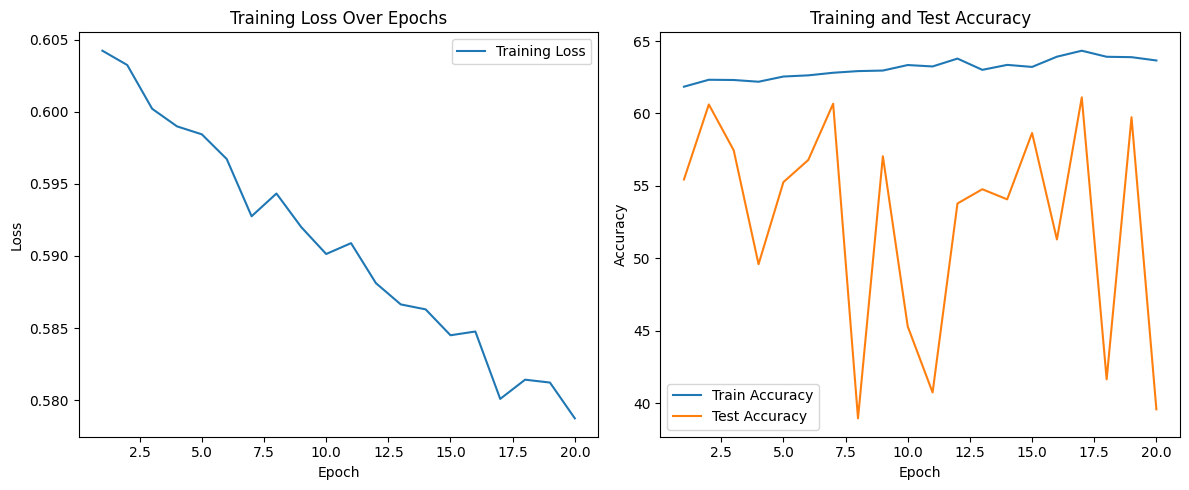

In [56]:
plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plotting training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Calculate the total number of labels in the test_loader
total_labels = 0
for _, labels in test_loader:
    total_labels += labels.size(0)

# Count the number of labels that are 1 and 0
num_ones = 0
num_zeros = 0
for _, labels in test_loader:
    for label in labels:
        if label == 1:
            num_ones += 1
        else:
            num_zeros += 1

# Calculate the percentage of labels that are 1 and 0
percent_ones = (num_ones / total_labels) * 100
percent_zeros = (num_zeros / total_labels) * 100

# Print the results
print(f"Percentage of labels that are 1: {percent_ones:.2f}%")
print(f"Percentage of labels that are 0: {percent_zeros:.2f}%")


Percentage of labels that are 1: 66.47%
Percentage of labels that are 0: 33.53%


In [ ]:
len(test_dataset)

NameError: name 'test_dataset' is not defined

## train for logistic regression with average vector

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Filter the DataFrame for only 'Progressor' or 'Controller'
df = dff_merged[dff_merged['Group'].isin(['Progressor', 'Controller'])]

# Encode 'Progressor' as 1 and 'Controller' as 0
label_encoder = LabelEncoder()
df['Group'] = label_encoder.fit_transform(df['Group'])  # This encodes 'Controller' as 0, 'Progressor' as 1


class EmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = list(dataframe['avg_embeddings'])
        self.labels = list(dataframe['Group'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return embedding, label

# Create the dataset
dataset = EmbeddingDataset(df)

# Split dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return torch.sigmoid(outputs)


KeyError: 'avg_embeddings'

In [ ]:
model = LogisticRegression(768, 1)  # 768 input features, 1 output feature
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        total_loss = 0

        for embeddings, labels in train_loader:
            # Reset the gradients back to zero
            optimizer.zero_grad()

            # Compute model output
            outputs = model(embeddings).squeeze()  # Squeeze is needed to adjust the dimensions for BCELoss

            # Calculate loss
            loss = criterion(outputs, labels.float())  # Labels need to be float for BCELoss

            # Backpropagation
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Accumulate loss
            total_loss += loss.item()

        # Print average loss for the epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

        # Evaluate the model on the test set
        evaluate_model(model, test_loader, criterion)

def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed
        for embeddings, labels in test_loader:
            outputs = model(embeddings).squeeze()

            # Compute loss
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()

            # Compute accuracy
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print loss and accuracy for the test set
    print(f'Test Loss: {total_loss/len(test_loader)}, Accuracy: {correct/total * 100:.2f}%')

# Initialize the model
model = LogisticRegression(768, 1)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)


In [ ]:
# prompt: print number of unique rows with unique groups (donorId)

print(result_df.groupby('donorId')['Group'].nunique().sum())


In [ ]:
result_df

In [ ]:
df

In [ ]:
# tcr_bert_hf_id = "wukevin/tcr-bert"
# tokenizer = AutoTokenizer.from_pretrained(tcr_bert_hf_id)
# model = AutoModel.from_pretrained(tcr_bert_hf_id)